<a href="https://colab.research.google.com/github/AAP9002/COMP34812-NLU-NLI/blob/main/NLI_Transformer_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer based Approach for NLI

In [1]:
RANDOM_STATE = 42
BATCH_SIZE = 16

In [2]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFRobertaForSequenceClassification

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Pre-process text

In [3]:
from huggingface_hub import snapshot_download

# set HF_TOKEN in your enviroment
snapshot_download(repo_id="aap9002/NLU-Coursework",  repo_type="dataset", allow_patterns=f"*", local_dir='./')

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

dev.csv:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

'/content'

In [4]:
def get_split_datasets():
  dev_set = pd.read_csv('dev.csv')
  train_set = pd.read_csv('train.csv')

  # create a test set out of validation if no test.csv exists
  try:
      test_set = pd.read_csv('test.csv')
  except:
      test_set = dev_set.sample(frac=0.2, random_state=RANDOM_STATE) # random state set for reproducability
      dev_set = dev_set.drop(test_set.index)

      test_set.reset_index()
      dev_set.reset_index()

  return train_set, dev_set, test_set

train_set, dev_set, test_set = get_split_datasets()

In [5]:
print(f"train set shape:{train_set.shape}")
train_set.head()

train set shape:(24432, 3)


,premise,hypothesis,label
0,yeah i don't know cut California in half or so...,Yeah. I'm not sure how to make that fit. Maybe...,1
1,actual names will not be used,"For the sake of privacy, actual names are not ...",1
2,The film was directed by Randall Wallace.,The film was directed by Randall Wallace and s...,1
3,"""How d'you know he'll sign me on?""Anse studie...",Anse looked at himself in a cracked mirror.,1
4,In the light of the candles his cheeks looked ...,Drew regarded his best friend and noted that i...,1


In [6]:
print(f"dev set shape:{dev_set.shape}")
dev_set.head()

dev set shape:(5389, 3)


,premise,hypothesis,label
0,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0
1,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1
2,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1
3,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0
4,I know that many of you are interested in addr...,The problems must be addressed,1


In [7]:
print(f"test set shape:{test_set.shape}")
test_set.head()

test set shape:(1347, 3)


,premise,hypothesis,label
381,"In any event, auditors need to make judgments ...","In any event, auditors do not have to make any...",0
2877,"Visit us, even if it's just for tea or a walk ...",The tea here is among the finest globally.,1
5314,As the sophistication and the number of edits ...,Improvements are costly to the agency.,1
2018,This most symbolic of Crete's religious relics...,Crete never lost possession of its important r...,0
2185,Just as he had experienced disappointment the ...,His betrayal made him feel completely numb and...,1


## Explore dataset

class balence
- Our dataset is labelled with a 0 or 1 to indicate a supporting or contradicting permissive hypothesis pair

<Axes: title={'center': 'Distribution of Classes'}, xlabel='Class', ylabel='Count'>

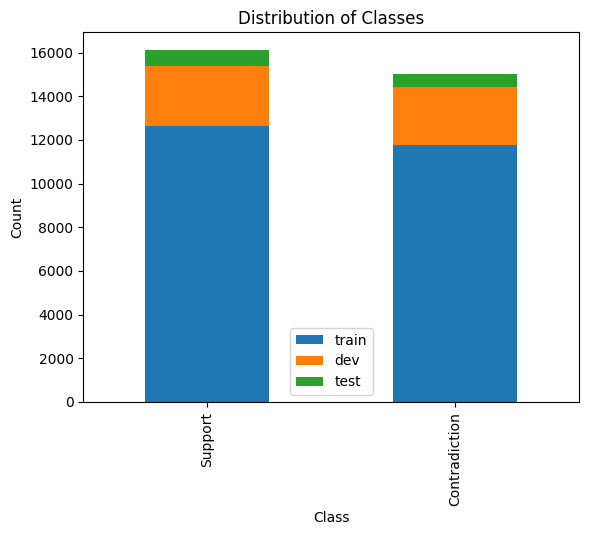

In [8]:
label_map = {
    0: 'Contradiction',
    1: 'Support'
}

labels_counts = [train_set['label'].value_counts(), dev_set['label'].value_counts(), test_set['label'].value_counts()]
labels_counts = pd.concat(labels_counts, axis=1)
labels_counts.columns = ['train', 'dev', 'test']

# set label names
labels_counts.index = labels_counts.index.map(label_map)

labels_counts.plot(kind="bar", stacked=True, title="Distribution of Classes", xlabel="Class", ylabel="Count")

Average word counts of premise and hypothosis

In [9]:
premise_counts = [train_set['premise'].str.split().str.len(), dev_set['premise'].str.split().str.len(), test_set['premise'].str.split().str.len()]
hypothesis_counts = [train_set['hypothesis'].str.split().str.len(), dev_set['hypothesis'].str.split().str.len(), test_set['hypothesis'].str.split().str.len()]

premise_counts = pd.concat(premise_counts, axis=1)
hypothesis_counts = pd.concat(hypothesis_counts, axis=1)

premise_counts.columns = ['train', 'dev', 'test']
hypothesis_counts.columns = ['train', 'dev', 'test']

print(f"Premise:\n{premise_counts.describe()}\n")
print(f"Hypothesis:\n{hypothesis_counts.describe()}\n")

Premise:
              train          dev         test
count  24432.000000  5389.000000  1347.000000
mean      18.915766    18.582668    18.540460
std       13.132731    12.086228    11.804328
min        0.000000     1.000000     1.000000
25%       10.000000    10.000000    10.000000
50%       16.000000    16.000000    16.000000
75%       24.000000    24.000000    24.000000
max      281.000000   139.000000    96.000000

Hypothesis:
              train          dev         test
count  24432.000000  5389.000000  1347.000000
mean      10.447323    10.457413    10.411284
std        4.784198     4.802937     4.651299
min        1.000000     1.000000     1.000000
25%        7.000000     7.000000     7.000000
50%       10.000000    10.000000    10.000000
75%       13.000000    13.000000    13.000000
max       45.000000    44.000000    30.000000



# RoBERTa Model

In [10]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Data preparation

Prepate input sequence and labels

In [11]:
def token_sequence(pairs, labels):
  encodings = tokenizer(
      [premise for premise, hypo in pairs.values],
      [hypo for premise, hypo in pairs.values],
      padding=True,
      truncation=True,
      return_tensors="tf"
  )
  labels = tf.one_hot(labels, depth=2) #comment if we wish to use multi-class
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
  return dataset


train_embeddings = token_sequence(train_set[['premise', 'hypothesis']], train_set['label'])
dev_embeddings = token_sequence(dev_set[['premise', 'hypothesis']], dev_set['label'])
test_embeddings = token_sequence(test_set[['premise', 'hypothesis']], test_set['label'])

In [12]:
train_batches = train_embeddings.batch(BATCH_SIZE)
dev_batches = dev_embeddings.batch(BATCH_SIZE)
test_batches = test_embeddings.batch(BATCH_SIZE)

### Fine tune Model

In [13]:
model = TFRobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)


N = 6  # Number of layers to freeze
for layer in model.roberta.encoder.layer[:N]:
    layer.trainable = False
print(f"Freezing first {N} layers of {len(model.roberta.encoder.layer)} roberta")

model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Freezing first 6 layers of 12 roberta
Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 82119938 (313.26 MB)
Non-trainable params: 42527232 (162.23 MB)
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = [tf.metrics.SparseCategoricalAccuracy()]
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5)]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(train_batches, validation_data=dev_batches , epochs=5)
# history = model.fit(dev_batches, validation_data=test_batches , epochs=5)

Epoch 1/5
1527/1527 [==============================] - 700s 436ms/step - loss: 0.4347 - binary_accuracy: 0.7791 - val_loss: 0.3495 - val_binary_accuracy: 0.8464
Epoch 2/5
 713/1527 [=============>................] - ETA: 5:42 - loss: 0.2944 - binary_accuracy: 0.8762

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  val_losses = history.history['val_loss']
  epochs = range(1, len(losses) + 1)

  accuracy = history.history['binary_accuracy']
  val_accuracy = history.history['val_binary_accuracy']

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, losses, 'bo', label='Training loss')
  plt.plot(epochs, val_losses, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()


plot_history(history)

## Evaluate Model

In [ ]:
import seaborn as sns

def plot_confussion(true, pred, title):
  cm = tf.math.confusion_matrix(true, pred)
  cm = cm.numpy()
  cm = cm / cm.sum(axis=1, keepdims=True)
  plt.figure(figsize=(8, 6))

  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  return cm


In [ ]:
predictions = model.predict(dev_batches)

print(predictions)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Test Set")

In [ ]:
predictions = model.predict(test_batches)

print(predictions)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

In [ ]:
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Test Set")
